In [1]:
import os
from functools import partial
import jax
import jax.numpy as jnp
import optax
import flax
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from flax import linen as nn
from flax.linen import summary
from flax.training import train_state
# from EICDense import *
# from ShuffleBlock import *
# from Accumulator import *
# from PseudoFFNet import *
# from EICNet import *
from HelperFunctions.binary_trident_helper_functions import *
from HelperFunctions.binary_mnist_dataloader import *
from HelperFunctions.metric_functions import *



%load_ext autoreload
%autoreload 2

2025-02-23 23:44:37.050639: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740383077.063932 2496630 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740383077.067815 2496630 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print(jax.devices())

[CudaDevice(id=0)]


In [3]:
def quantize_params(params, bits = 8):
    """
    Quantizes the parameters of the model to given number of bits.
    Args:
        params: flax model parameters
        bits: number of bits to quantize to
    Returns:
        quantized_params: quantized flax model parameters
    """

    scale = 2**(bits - 1) - 1
    params = jax.tree.map(
        lambda p: jnp.round(p * scale) / scale, params
    )

    return params

# Recursively print gradients
def print_grads(grads):
    def traverse_and_print(d, prefix=""):
        if isinstance(d, dict):
            for key, value in d.items():
                traverse_and_print(value, prefix=f"{prefix}/{key}" if prefix else key)
        else:
            # Materialize gradient and print
            concrete_value = jax.device_get(d)
            print(f"{prefix}: {concrete_value.shape}, {concrete_value}")

In [4]:
class EICDense(nn.Module):
    """
    Pseudo-dense layer using EIC Cores.
    Args:
    in_size: int, number of input neurons
    out_size: int, number of output neurons
    threshold: float, threshold for binary activation
    noise_sd: flaat, standard deviation of noise for binary activation
    key: jax.random.PRNGKey, random key

    Returns:
    x: jnp.ndarray, output of the layer
    """

    in_size: int
    out_size: int

    def setup(self):
        """
        Set up dependent parameters
        """
        self.out_blocks = max(self.out_size//256, 1) # number of blocks required at the output 
        self.in_blocks = max(self.in_size//256, 1) # number of bloacks required at the input


        self.num_cores = self.out_blocks * self.in_blocks # number of cores required
        self.W = self.param(
            "weights",
            lambda key, shape: nn.initializers.xavier_normal()(key, shape),
            (self.out_blocks, self.in_blocks, 256, 256)
        )


    def __call__(self, x):
        """
        Forward pass of the layer
        Args:
        x: jnp.ndarray (batch_size, in_size), input to the layer
        
        Returns:
        x: jnp.ndarray, output of the layer
        """

        assert x.shape[-1] == self.in_size, f"Input shape is incorrect. Got {x.shape[-1]}, expected {self.in_size}"

        x_reshaped = x.reshape(x.shape[0], self.in_blocks, 256) # organize x into blocks of 256 for every batch

        # make sure that the weights are positive
        W_pos= self.W #jax.nn.softplus(self.W)

        # quantize weights
        # W_pos = quantize_params(W_pos, bits = 8)

        y = jnp.einsum("ijkl,bjl->bijk", W_pos, x_reshaped)


        return y
    

# define the accumulator module
class Accumulator(nn.Module):
    """
    Accumulating the EICDense outputs. 
    Since the EICDense generates pseudo-feedforward outputs, we use a learnable accumulation matrix that minimizes error
    between the true feedforward output and the EIC output.

    Args:
        in_block_size: int, number of 256-sized blocks. This should be the .shape[0] of the EICDense output
    """

    in_block_size: int

    def setup(self):
        """
        Set up the weights for the accumulator
        """

        self.W = self.param(
            "weights",
            nn.initializers.xavier_normal(),
            (self.in_block_size, 256, 256)
        )


    @nn.compact
    def __call__(self, x):
        """
        Forward pass of the accumulator
        Args:
        x: jnp.ndarray, input to the accumulator
        
        Returns:
        x: jnp.ndarray, output of the accumulator
        """

        assert x.shape[1] == self.in_block_size, "Input shape is incorrect"
        # assert x.shape[1] == self.out_block_size, "Input shape is incorrect"

        # ensure positive 
        W_pos = self.W #jax.nn.softplus(self.W)
        # W_pos = quantize_params(W_pos, bits = 8)
        
        x = jnp.einsum("bijk->bik", x)
        y = jnp.einsum("ijk,bik->bik", W_pos, x) 

        # flatten y before returning
        y = y.reshape((y.shape[0], -1)) # (batch_size, out_size)

        return y

class PermuteBlock(nn.Module):
    """
    Contains two fixed permutation matrices (pos and neg) to shuffle the input block-wise.
    """

    input_size: int
    permute_block_size: int = 16 # previously 64
    core_input_size: int = 256

    def setup(self):
        """
        Set up permutation matrices
        """


        self.num_slots = self.core_input_size // self.permute_block_size # should be 16 in the latest iteration
        self.num_subvectors = self.input_size // self.core_input_size # for input_size = 1024, should be 256

        self.tau = self.param(
            'tau',
            nn.initializers.constant(10),
            ()
        ) # temperature paramter

        # generate two independent permutation sequences
        key = jax.random.key(1245)
        key1, key2 = jax.random.split(key)
        p1 = jax.random.permutation(key1, self.num_slots)
        p2 = jax.random.permutation(key2, self.num_slots) # jnp.roll(p1, shift = 1) #

        # generate permutation matrices
        m1 = jnp.eye(self.num_slots)*self.tau
        m2 = jnp.eye(self.num_slots)*self.tau

        # generate the permutation matrices
        self.Ppos = m1[p1]
        self.Ppos = jax.nn.softmax(self.Ppos, axis = -1)
        self.Pneg = m2[p2]
        self.Pneg = jax.nn.softmax(self.Pneg, axis = -1)

    
    def __call__(self, x):
        """
        Apply permutations and return (xpos - xneg)
        Args:
        x: jnp.ndarray, input vector. Shape: (batch_size, input_size) e.g. (32, 2048)
        Returns:
        xpos - xneg: jnp.ndarray, difference of permuted inputs. Shape: (batch_size, input_size)
        """

        assert x.shape[-1] == self.input_size, f"Input shape is incorrect. Got {x.shape[-1]}, expected {self.input_size}"
        assert self.num_subvectors * self.num_slots * self.permute_block_size == self.input_size, f"Inconsistent metrics!"

        x = x.reshape(x.shape[0], self.num_subvectors, self.num_slots, self.permute_block_size) # first dimension must be the batch size

        xpos = jnp.einsum('ij,bsjp->bsip', self.Ppos, x)
        xneg = jnp.einsum('ij,bsjp->bsip', self.Pneg, x)

        xout = xpos - xneg

        xout = xout.reshape((x.shape[0], self.input_size))

        return xout
    


In [7]:
# class EICConvNet(nn.Module):
#     """
#     EICNetwork -> Might supersede PseudoFFNet... in progress
#     1024 - 2048 - 256 - 10
#     """
#     def setup(self):
#         self.p1 = PermuteBlock(input_size = 16*16)
#         self.conv1 = nn.Conv(features = 1, kernel_size = (4,4), padding=3, strides=2)
#         self.fc1 = EICDense(in_size = 16*16, out_size = 2048) # (8, 4, 256)
#         self.ac1 = Accumulator(in_block_size = 2048//256) # (2048,)
#         self.p2 = PermuteBlock(input_size = 2048)
#         # self.fc2 = EICDense(in_size = 2048, out_size = 1024) # (8, 4, 256)
#         # self.ac2 = Accumulator(in_block_size = 1024//256) # (2048,)
#         # self.p3 = PermuteBlock(input_size = 1024)
#         self.fc3 = EICDense(in_size = 2048, out_size = 256) # (8, 4, 256)
#         self.ac3 = Accumulator(in_block_size = 256//256) # (2048,)

#     def __call__(self, x):
#         nsd = 5e-2
#         x = self.conv1(x)
#         # print(f"Conv lr: {x}")
#         x = jax.nn.leaky_relu(x)#custom_binary_gradient(x, threshold = 0.0, noise_sd = nsd, key = jax.random.key(0))
        
#         x = nn.avg_pool(x, window_shape=(2, 2), strides=(1, 1), padding='SAME')
#         x = x.reshape((x.shape[0], 16*16))
#         # print(x.shape)
#         x = self.p1(x)
#         # print(x.shape)
#         x = self.fc1(x)
#         # print(f"fc1 {x}")
#         x = custom_binary_gradient(x, threshold = 0.0, noise_sd = nsd, key = jax.random.key(0)) #jax.nn.relu(x) # custom_binary_gradient(x, threshold = 0.0, noise_sd = 0.1, key = jax.random.key(0))
#         # print(f"fc1 {x}")
#         x = self.ac1(x)
#         x = custom_binary_gradient(x, threshold = 0.0, noise_sd = nsd, key = jax.random.key(1))
#         # print(f"ac1 {x}")
#         x = self.p2(x)
#         # x = self.fc2(x)
#         # x = custom_binary_gradient(x, threshold = 0.0, noise_sd = nsd, key = jax.random.key(0))
#         # # print(f"fc2 {x}")
#         # x = self.ac2(x)
#         # x = custom_binary_gradient(x, threshold = 0.0, noise_sd = nsd, key = jax.random.key(0))
#         # # print(f"ac2 {x}")
#         # x = self.p3(x)
#         x = self.fc3(x)
#         x = custom_binary_gradient(x, threshold = 0.0, noise_sd = nsd, key = jax.random.key(3))
#         # print(f"fc3 {x}")
#         x = self.ac3(x)
#         x = x[:, :10]
#         return x

In [44]:
class EICConvNet(nn.Module):
    """
    EICNetwork -> Might supersede PseudoFFNet... in progress
    1024 - 2048 - 256 - 10
    """
    def setup(self):
        self.conv1 = nn.Conv(features = 1, kernel_size = (4,4), padding=3, strides=2)
        self.fc1 = EICDense(in_size = 16*16, out_size = 2048*2) # (16, 4, 256)
        self.ac1 = Accumulator(in_block_size = 8*2) # (4096,)
        self.fc2 = EICDense(in_size = 2048*2, out_size = 1024*2) # (8, 16, 256)
        self.ac2 = Accumulator(in_block_size = 4*2) # (2048,)
        self.fc3 = EICDense(in_size = 1024*2, out_size = 256) # (8, 4, 256)
        self.ac3 = Accumulator(in_block_size = 1) # (2048,)
        

    def __call__(self, x):
        nsd = 0.05
        key = jax.random.key(2425)
        x = self.conv1(x)
        # print(f"Conv lr: {x}")
        x = jax.nn.leaky_relu(x)#custom_binary_gradient(x, threshold = 0.0, noise_sd = nsd, key = jax.random.key(0))
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(1, 1), padding='SAME')
        x = x.reshape((x.shape[0], 16*16))
        # print(x.shape)
        # print(x.shape)
        x = self.fc1(x)
        # print(f"fc1 {x}")
        key, subkey = jax.random.split(key)
        x = custom_binary_gradient(x, threshold = 0.0, noise_sd = nsd, key = subkey) #jax.nn.relu(x) # custom_binary_gradient(x, threshold = 0.0, noise_sd = 0.1, key = jax.random.key(0))
        # print(f"fc1 {x}")
        x = self.ac1(x)
        key, subkey = jax.random.split(key)
        x = custom_binary_gradient(x, threshold = 0.0, noise_sd = nsd, key = subkey)
        # print(f"ac1 {x}")
        # x = self.p2(x)
        x = self.fc2(x)
        key, subkey = jax.random.split(key)
        x = custom_binary_gradient(x, threshold = 0.0, noise_sd = nsd, key = subkey)
        # # print(f"fc2 {x}")
        x = self.ac2(x)
        key, subkey = jax.random.split(key)
        x = custom_binary_gradient(x, threshold = 0.0, noise_sd = nsd, key = subkey)
        # # print(f"ac2 {x}")
        # x = self.p3(x)
        x = self.fc3(x)
        key, subkey = jax.random.split(key)
        x = custom_binary_gradient(x, threshold = 0.0, noise_sd = nsd, key = subkey)
        # print(f"fc3 {x}")
        x = self.ac3(x)

        # use population coding to get the final output
        x = x[:, :250].reshape(x.shape[0], 10, 25)
        pop_logits = jnp.average(x, axis = -1)


        # x = x[:, :10]
        return pop_logits

In [6]:
# load the data
DATA_PATH = f"/local_disk/vikrant/datasets/"
# (train_inputs, train_labels), (val_inputs, val_labels), (test_inputs, test_labels) = load_and_process_mnist(data_path=DATA_PATH, binarize = True)
# train_inputs[0].shape

def get_datasets():
    """Load MNIST train, validation, and test datasets into memory."""
    # Load MNIST dataset
    ds_builder = tfds.builder('mnist', data_dir=DATA_PATH)
    ds_builder.download_and_prepare()
    
    # Load full datasets as numpy arrays
    full_train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
    full_test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))

    # Normalize images
    full_train_ds['image'] = jnp.float32(full_train_ds['image']) / 255.
    full_test_ds['image'] = jnp.float32(full_test_ds['image']) / 255.

    # Concatenate train and test datasets for splitting
    all_images = jnp.concatenate([full_train_ds['image'], full_test_ds['image']], axis=0)
    all_labels = jnp.concatenate([full_train_ds['label'], full_test_ds['label']], axis=0)

    # Train-validation-test split: 50k-10k-10k
    train_images, val_images, test_images = all_images[:50000], all_images[50000:60000], all_images[60000:]
    train_labels, val_labels, test_labels = all_labels[:50000], all_labels[50000:60000], all_labels[60000:]

    # Resize images to 16x16
    def resize_images(images, new_size):
        resized = tf.image.resize(images, new_size, method='bilinear')
        return jnp.array(resized)

    train_images = resize_images(train_images, (16, 16))
    val_images = resize_images(val_images, (16, 16))
    test_images = resize_images(test_images, (16, 16))

    # Binarize images
    def binarize_images(images, threshold=0.5):
        return jnp.where(images < threshold, 0.0, 1.0)

    train_images = binarize_images(train_images)
    val_images = binarize_images(val_images)
    test_images = binarize_images(test_images)

    # Prepare datasets in similar structure as original
    train_ds = {'image': train_images, 'label': train_labels}
    val_ds = {'image': val_images, 'label': val_labels}
    test_ds = {'image': test_images, 'label': test_labels}

    return train_ds, val_ds, test_ds


def get_datasets_28():
    """Load MNIST train, validation, and test datasets into memory."""
    # Load MNIST dataset
    ds_builder = tfds.builder('mnist', data_dir=DATA_PATH)
    ds_builder.download_and_prepare()
    
    # Load full datasets as numpy arrays
    full_train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
    full_test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))

    # Normalize images
    full_train_ds['image'] = jnp.float32(full_train_ds['image']) / 255.
    full_test_ds['image'] = jnp.float32(full_test_ds['image']) / 255.

    # Concatenate train and test datasets for splitting
    all_images = jnp.concatenate([full_train_ds['image'], full_test_ds['image']], axis=0)
    all_labels = jnp.concatenate([full_train_ds['label'], full_test_ds['label']], axis=0)

    # Train-validation-test split: 50k-10k-10k
    train_images, val_images, test_images = all_images[:50000], all_images[50000:60000], all_images[60000:]
    train_labels, val_labels, test_labels = all_labels[:50000], all_labels[50000:60000], all_labels[60000:]

    # Resize images to 16x16
    def resize_images(images, new_size):
        resized = tf.image.resize(images, new_size, method='bilinear')
        return jnp.array(resized)

    # train_images = resize_images(train_images, (16, 16))
    # val_images = resize_images(val_images, (16, 16))
    # test_images = resize_images(test_images, (16, 16))

    # Binarize images
    def binarize_images(images, threshold=0.5):
        return jnp.where(images < threshold, 0.0, 1.0)

    train_images = binarize_images(train_images)
    val_images = binarize_images(val_images)
    test_images = binarize_images(test_images)

    # Prepare datasets in similar structure as original
    train_ds = {'image': train_images, 'label': train_labels}
    val_ds = {'image': val_images, 'label': val_labels}
    test_ds = {'image': test_images, 'label': test_labels}

    return train_ds, val_ds, test_ds


In [25]:
# some additional functions
def cross_entropy_loss(*, logits, labels):
    one_hot_labels = jax.nn.one_hot(labels, num_classes = 10)
    loss = optax.softmax_cross_entropy(logits = logits, labels = one_hot_labels).mean()
    return loss

def compute_metrics(*, logits, labels):
  loss = cross_entropy_loss(logits=logits, labels=labels)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  metrics = {
      'loss': loss,
      'accuracy': accuracy,
  }
  return metrics


# create train state for conv net
def create_train_state_conv(rng, learning_rate, batch_size, momentum = 0.9):
  """
  Create a training state for Flax
  """

  eic_model = EICConvNet()
  params = eic_model.init(rng, jnp.ones([1, 28, 28, 1]))['params']
  # opt = optax.sgd(learning_rate = learning_rate, momentum= momentum)
  opt = optax.adam(learning_rate=learning_rate)
  return train_state.TrainState.create(
    apply_fn=eic_model.apply, params=params, tx=opt
  )

# create learning rate schedule
def create_learning_rate_sch(config, base_learning_rate, steps_per_epoch):
    """
    Create a learning rate schedule
    """

    # warm up
    warmup_fn = optax.linear_schedule(
        init_value = 0.,
        end_value = base_learning_rate,
        transition_steps = config['warmup_epochs']*steps_per_epoch
    )

    # cosine schedule
    cosine_epochs = max(config['num_epochs'] - config['warmup_epochs'], 1)
    cosine_fn = optax.cosine_decay_schedule(
        init_value = base_learning_rate,
        decay_steps = cosine_epochs*steps_per_epoch
    )

    # combine warmup + cosine 
    schedule_fn = optax.join_schedules(
        schedules=[warmup_fn, cosine_fn],
        boundaries=[config['warmup_epochs']*steps_per_epoch]
    )

    return schedule_fn



config = {
   'warmup_epochs' : 20,
   'steps_per_epoch' : 100,
   'num_epochs': 50,
}

# lr_fn = create_learning_rate_sch(config=config, base_learning_rate=1e-3, steps_per_epoch=config['steps_per_epoch'])

In [8]:
# create a training step
@jax.jit
def train_step_conv(state, batch):
    """
    Train for single step
    """

    def loss_fn(params):
        logits = EICConvNet().apply({'params': params}, batch['image'])
        loss = cross_entropy_loss(logits = logits, labels = batch['label'])
        return loss, logits
    
    grad_fn = jax.value_and_grad(loss_fn, has_aux = True)
    (_, logits), grads = grad_fn(state.params)

    # Log gradients to a file
    def log_grads(grads, log_file_path):
        with open(log_file_path, "a") as log_file:
            log_file.write("Gradient Norms per Layer:\n")
            for k, v in grads.items():
                # Compute the norm of the gradients for each layer
                layer_norm = jax.tree_util.tree_map(lambda g: jnp.linalg.norm(g), v)
                log_file.write(f"Layer {k}, Gradient Norms: {layer_norm}\n")
            log_file.write("\n")

    # # Ensure the logging directory exists
    # pth = f"./Logs/conv_grads.txt"
    # os.makedirs(os.path.dirname(pth), exist_ok=True)
    # log_grads(grads, pth)


    state = state.apply_gradients(grads=grads)
    metrics = compute_metrics(logits = logits, labels = batch['label'])
    return state, metrics



# train function conv
def train_epoch(state, train_ds, batch_size, epoch, rng):
    """
    Trains for a single epoch
    """

    train_ds_size = len(train_ds['image'])
    steps_per_epoch = train_ds_size // batch_size

    perms = jax.random.permutation(rng, train_ds_size)
    perms = perms[:steps_per_epoch * batch_size] # drop incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))

    # batch_metrics = []

    for perm in perms:
        batch = {k : v[perm, ...] for k, v in train_ds.items()}
        state, metrics = train_step_conv(state, batch) # using the conv model

        # batch_metrics.append(metrics)

    # compute mean across the batch
    # batch_metrics_np = jax.device_get(batch_metrics)
    # epoch_metrics_np = {
    #   k: np.mean([metrics[k] for metrics in batch_metrics_np])
    #   for k in batch_metrics_np[0]}

    # print(f"Train epoch: {epoch}")
    # print(f"Training Accuracy: {epoch_metrics_np['accuracy']*100 :.02f} %, Loss: {epoch_metrics_np['loss'] :.02f}")
    # print('train epoch: %d, loss: %.4f, accuracy: %.2f' % (
    #     epoch, epoch_metrics_np['loss'], epoch_metrics_np['accuracy'] * 100))

    return state


In [9]:
# training with learning rate schedule
@partial(jax.jit, static_argnums=2)
def train_step_sch(state, batch, learning_rate_fn):
    def loss_fn(params):
        logits = EICConvNet().apply({'params': params}, batch['image'])
        one_hot_labels = jax.nn.one_hot(batch['label'], num_classes = 10)
        loss = jnp.mean(optax.softmax_cross_entropy(logits = logits, labels = one_hot_labels))

        return loss, logits
    
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, logits), grads = grad_fn(state.params)
    new_state = state.apply_gradients(grads = grads)
    metrics = compute_metrics(logits=logits, labels=batch['label'])
    lr = learning_rate_fn(state.step)
    metrics['learning_rate'] = lr
    return new_state, metrics

def train_epoch_sch(state, train_ds, batch_size, epoch, learning_rate_fn, rng):
  """Trains for a single epoch."""
  train_ds_size = len(train_ds['image'])
  steps_per_epoch = train_ds_size // batch_size
  perms = jax.random.permutation(rng, len(train_ds['image']))
  perms = perms[:steps_per_epoch * batch_size]
  perms = perms.reshape((steps_per_epoch, batch_size))
  batch_metrics = []
  for perm in perms:
    batch = {k: v[perm, ...] for k, v in train_ds.items()}
    state, metrics = train_step_sch(state, batch, learning_rate_fn)
    batch_metrics.append(metrics)

#   # compute mean of metrics across each batch in epoch.
#   batch_metrics = jax.device_get(batch_metrics)
#   epoch_metrics = {
#       k: np.mean([metrics[k] for metrics in batch_metrics])
#       for k in batch_metrics[0]}

#   logging.info('train epoch: %d, loss: %.4f, accuracy: %.2f', epoch,
#                epoch_metrics['loss'], epoch_metrics['accuracy'] * 100)

  return state

def create_train_state_sch(rng, learning_rate_fn):
  """Creates initial `TrainState`."""
  eic_net = EICConvNet()
  params = eic_net.init(rng, jnp.ones([1, 28, 28, 1]))['params']
  tx = optax.adam(learning_rate_fn)
  return train_state.TrainState.create(
      apply_fn=eic_net.apply, params=params, tx=tx)





In [10]:
# eval function conv
def eval_model_conv(params, val_ds):
    """
    Evaluate the model
    """
    metrics = eval_step_conv(params, val_ds)
    metrics = jax.device_get(metrics)
    summary = jax.tree.map(lambda x: x.item(), metrics)
    return summary['loss'], summary['accuracy']

# test accutacy
def eval_test_conv(params, test_ds):
    """
    Evaluate the model on test set
    """
    metrics = eval_step_conv(params, test_ds)
    metrics = jax.device_get(metrics)
    summary = jax.tree.map(lambda x: x.item(), metrics)
    return summary['loss'], summary['accuracy']

def evaluate_in_batches(params, dataset, batch_size):
    total_loss, total_accuracy, total_samples = 0.0, 0.0, 0
    for i in range(0, len(dataset['image']), batch_size):
        batch = {
            'image': dataset['image'][i:i+batch_size],
            'label': dataset['label'][i:i+batch_size]
        }
        metrics = eval_step_conv(params, batch)
        loss, accuracy = metrics['loss'], metrics['accuracy']
        # Optionally, convert to CPU if necessary
        loss, accuracy = jax.device_get((loss, accuracy))
        batch_size_actual = len(batch['label'])
        total_loss += loss * batch_size_actual
        total_accuracy += accuracy * batch_size_actual
        total_samples += batch_size_actual
    return total_loss / total_samples, total_accuracy / total_samples

# evaluation step conv
@jax.jit
def eval_step_conv(params, batch):
    """
    Evaluate the model
    """

    logits = EICConvNet().apply({'params': params}, batch['image'])
    return compute_metrics(logits = logits, labels = batch['label'])

In [11]:
train_ds, val_ds, test_ds = get_datasets_28()

I0000 00:00:1740383097.734757 2496630 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 40782 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:21:00.0, compute capability: 8.9


## No learning rate schedule

In [15]:
rng = jax.random.key(87095)
rng, init_rng = jax.random.split(rng)
learning_rate = 1e-2
momentum = 0.9
batch_size = 5
state = create_train_state_conv(init_rng, learning_rate, batch_size)
del init_rng  # Must not be used anymore.

val_acc = []
train_acc = []

In [16]:
num_epochs = 5
for epoch in range(1, num_epochs + 1):
  # Use a separate PRNG key to permute image data during shuffling
  rng, input_rng = jax.random.split(rng)

   # Evaluate on the test set after each training epoch 
  val_loss, val_accuracy = evaluate_in_batches(state.params, val_ds, 32)
  print(f"Validation Accuracy: {val_accuracy*100 :.02f} %, Loss: {val_loss :.02f}")

  # # Evaluate on the train set after each training epoch 
  # train_loss, train_accuracy = eval_model_conv(state.params, train_ds)
  # print(f"Train Accuracy: {train_accuracy*100 :.02f} %, Loss: {train_loss :.02f}")
  
  
  # Run an optimization step over a training batch
  state = train_epoch(state, train_ds, batch_size, epoch, input_rng)

  val_acc.append(val_accuracy)
  # train_acc.append(train_accuracy)

Validation Accuracy: 9.52 %, Loss: 2.65
Validation Accuracy: 9.63 %, Loss: 4.51


KeyboardInterrupt: 

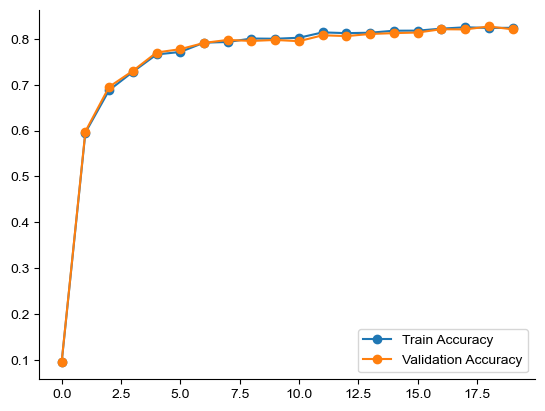

In [ ]:
fig, ax = plt.subplots()
ax.plot(train_acc, 'o-', label='Train Accuracy')
ax.plot(val_acc, 'o-', label='Validation Accuracy')
ax.legend()

sns.despine()


In [ ]:
# using same relu network for evaluation
test_loss, test_accuracy = eval_test_conv(state.params, test_ds)

print(f"Test set")
print(f"Accuracy: {test_accuracy*100 :.03f} %, Loss: {test_loss:.03f}")

2025-02-23 22:11:28.416745: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 625.00MiB (rounded to 655360000)requested by op 
2025-02-23 22:11:28.416825: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] ***x********************************************xx***************************_______________________
2025-02-23 22:11:28.416849: W external/xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1181] Autotuning candidate failed with out of memory error. Consider disabling correctness checking (i.e. --xla_gpu_autotune_level=3) to reduce autotuning memory usage.


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 655360000 bytes.

## Learning Rate Schedule

In [50]:
## using lr schedule
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
learning_rate = 2e-3
momentum = 0.9
batch_size = 512
lr_fn = create_learning_rate_sch(config=config, base_learning_rate=learning_rate, steps_per_epoch=config['steps_per_epoch'])
state = create_train_state_sch(init_rng, lr_fn)
del init_rng  # Must not be used anymore.

val_acc = []
train_acc = []

In [51]:
num_epochs = 50
for epoch in tqdm(range(1, num_epochs + 1)):
  # Use a separate PRNG key to permute image data during shuffling
  rng, input_rng = jax.random.split(rng)

  # Evaluate on the val set after each training epoch
  val_loss, val_accuracy = evaluate_in_batches(state.params, val_ds, 32)
  train_loss, train_accuracy = evaluate_in_batches(state.params, train_ds, 32)
  # val_loss, val_accuracy = eval_model_conv(state.params, val_ds))
  print(f"Epoch: {epoch}, Validation Accuracy: {val_accuracy*100 :.02f} %, Loss: {val_loss :.02f}")

  
  
  # Run an optimization step over a training batch
  state = train_epoch_sch(state, train_ds, batch_size, epoch, lr_fn, input_rng)

  # Evaluate on the train set after each training epoch 
  # train_loss, train_accuracy = eval_model_conv(state.params, train_ds)
  # print(f"Train Accuracy: {train_accuracy*100 :.02f} %, Loss: {train_loss :.02f}")

  train_acc.append(train_accuracy*100)
  val_acc.append(val_accuracy*100)

  # del val_accuracy

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, Validation Accuracy: 10.23 %, Loss: 2.56
Epoch: 2, Validation Accuracy: 37.15 %, Loss: 2.02
Epoch: 3, Validation Accuracy: 34.42 %, Loss: 1.80
Epoch: 4, Validation Accuracy: 64.30 %, Loss: 1.00
Epoch: 5, Validation Accuracy: 76.98 %, Loss: 0.70
Epoch: 6, Validation Accuracy: 83.75 %, Loss: 0.55
Epoch: 7, Validation Accuracy: 86.95 %, Loss: 0.44
Epoch: 8, Validation Accuracy: 88.63 %, Loss: 0.39
Epoch: 9, Validation Accuracy: 91.07 %, Loss: 0.31
Epoch: 10, Validation Accuracy: 91.95 %, Loss: 0.28
Epoch: 11, Validation Accuracy: 92.60 %, Loss: 0.26
Epoch: 12, Validation Accuracy: 92.69 %, Loss: 0.25
Epoch: 13, Validation Accuracy: 93.93 %, Loss: 0.21
Epoch: 14, Validation Accuracy: 93.90 %, Loss: 0.20
Epoch: 15, Validation Accuracy: 94.12 %, Loss: 0.19
Epoch: 16, Validation Accuracy: 94.61 %, Loss: 0.19
Epoch: 17, Validation Accuracy: 94.39 %, Loss: 0.19
Epoch: 18, Validation Accuracy: 94.22 %, Loss: 0.19
Epoch: 19, Validation Accuracy: 95.29 %, Loss: 0.16
Epoch: 20, Validation

In [52]:
# using same relu network for evaluation
test_loss, test_accuracy = evaluate_in_batches(state.params, test_ds, 32)


print(f"Test set")
print(f"Accuracy: {test_accuracy*100 :.03f} %, Loss: {test_loss:.03f}")

Test set
Accuracy: 97.300 %, Loss: 0.104


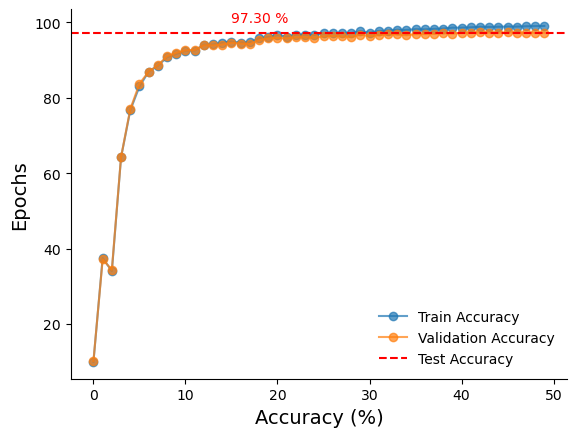

In [54]:
fig, ax = plt.subplots()
ax.plot(train_acc, 'o-', label='Train Accuracy', alpha = .7)
ax.plot(val_acc, 'o-', label='Validation Accuracy', alpha=.7)
ax.set_ylabel("Epochs", fontsize = 14)
ax.set_xlabel("Accuracy (%)", fontsize = 14)
ax.axhline(test_accuracy*100, color = 'red', linestyle = '--', label = 'Test Accuracy')
ax.text(x = 15, y = 100, s = f"{test_accuracy*100:.02f} %", color = 'red')
ax.legend(frameon = False)

sns.despine()
# plt.savefig(f"Figures/binary_pop_coding_256_4096_2048_256_20250224.pdf", dpi = 300, bbox_inches = 'tight')

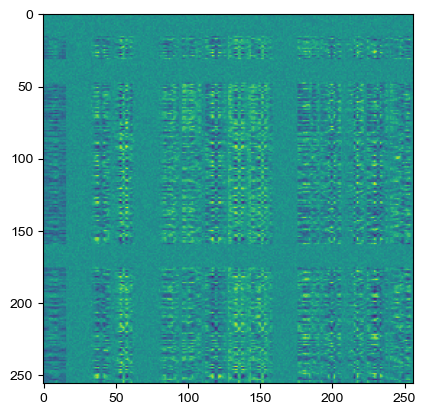

In [179]:
w_fc1 = state.params['fc1']['weights']

plt.imshow(w_fc1[2,0,:,:])

In [16]:
net = EICConvNet()
im0 = test_ds['image'][0].reshape((1, 28, 28, 1))
params_ = net.init(rng, im0)['params']
out = net.apply({'params': params_}, im0)

print(out)
print(jax.nn.softmax(out))

[[-2.8837397   1.1891283   2.3806405   0.47990656 -0.78506505 -1.9458706
  -0.9334929  -0.32513613 -4.1988626   0.6839105 ]]
[[0.00287104 0.16860232 0.5550482  0.08295689 0.02341436 0.00733416
  0.02018463 0.03708744 0.00077071 0.10173027]]


In [176]:
state.params['p3']['tau']

KeyError: 'p3'

In [ ]:
x_test = jnp.arange(0, 10, 0.1)
y = custom_binary_gradient(x_test, threshold = 0.0, noise_sd = 0.1, key = jax.random.PRNGKey(0))
dy = vmap(jax.grad(custom_binary_gradient)(x))(x_test, threshold = 0.0, noise_sd = 0.1, key = jax.random.PRNGKey(0))

plt.plot(x_test, y, dy)

NameError: name 'x' is not defined

In [22]:
xx = jax.random.normal(jax.random.key(0), (1, 20))
print(xx)
xx = xx.reshape(xx.shape[0], 10, -1)
xx = jnp.average(xx, axis = -1)
xx = jax.nn.softmax(xx)
print(xx)

[[ 1.0545162  -0.96928865 -0.5946021  -0.03188572  2.4109333  -1.8784491
  -0.7847696  -0.31370842  0.3337089   1.7677035  -1.0277646   1.4111718
  -0.5084971  -0.5263775   0.5031504   1.0549793  -0.08740733  0.7958167
   2.6565616  -0.5822906 ]]
[[0.07074967 0.04956526 0.08847997 0.03914588 0.19388019 0.08212461
  0.04041079 0.14776143 0.09661546 0.19126686]]
